In [22]:
import json

from tqdm.notebook import tqdm

import itertools
import os
import random
import pandas as pd

# data & plotting
from matplotlib import pyplot as plt
import seaborn as sns

#from solc import install_solc
#install_solc('v0.4.25')

from utils import get_contract

In [33]:
insertsort = get_contract('contracts/InsertionSort.sol', 'Median')
mergesort = get_contract('contracts/MergeSort.sol', 'Median')
quickselect = get_contract('contracts/QuickSort.sol', 'SelectK')
chainlink = get_contract('contracts/Chainlink.sol', 'Median2')
band = get_contract('contracts/Band.sol', 'MedianAggregator')

## Run tests

In [34]:
FILENAME = 'results.csv'

if os.path.exists(FILENAME):
    df = pd.read_csv(FILENAME, index_col=0)
else:
    df = pd.DataFrame({
        'length': pd.Series([], dtype='int'), 
        'gas_cost': pd.Series([], dtype='int'), 
        'type': pd.Series([], dtype='str'), 
        'arr': pd.Series([], dtype='int'), 
    })

In [35]:
def _median(arr):
    arr_copy = arr[:]
    arr_copy.sort()
    n = len(arr)
    if n % 2 == 1:
        return arr_copy[n // 2]
    else:
        return (arr_copy[n // 2 - 1] + arr_copy[n // 2]) / 2

def _arr_to_str(arr):
    return '-'.join([str(x) for x in arr])

def _insert(df, row):
    insert_loc = df.index.max()

    if pd.isna(insert_loc):
        df.loc[0] = row
    else:
        df.loc[insert_loc + 1] = row

NPERMS = 20
MAX_ARRAY_SIZE = 20

# test only odd-length arrays
# reason: even-length is more compute intensive,
#         but no more secure against malicious actors
for n in tqdm(range(1, MAX_ARRAY_SIZE + 2, 2)):
    
    arr = list(range(10, 10 * n + 1, 10))
    
    for r in range(NPERMS):
        
        assert len(arr) == n, print(len(arr), n)
        random.shuffle(arr)
        
        arr_str = _arr_to_str(arr)
        
        for (typ, fn) in [
            ('insertion-sort', insertsort.functions.compute),
            ('merge-sort', mergesort.functions.compute),
            ('quick-sort', quickselect.functions.median),
            #('quick-select-pivot', quickselect.functions.medianWithPivot),
            ('chainlink-inplace', chainlink.functions.calculateInplace),
            ('chainlink', chainlink.functions.calculate),
            ('band', band.functions.aggregate),
        ]:
            if ((df.type == typ) & (df.arr == arr_str)).any():
                # already computed
                # TODO: consider `df.set_index(['year', 'month'])`
                continue
                
            if typ == 'band':
                fn_ = fn(arr[:], len(arr))
            else:
                fn_ = fn(arr[:])
                
            #print(typ, fn)
            #print(arr)
            
            gas_cost = fn_.estimateGas()
            res = fn_.call()
            
            #print(res, _median(arr))
            
            assert res == _median(arr) # extra check, just in case
            row = [n, gas_cost, typ, arr_str]
            _insert(df, row)

    # save periodically
    df.to_csv(FILENAME)

  0%|          | 0/11 [00:00<?, ?it/s]

In [36]:
# color palettes
coolors = ["ff595e","ffca3a","8ac926","1982c4","6a4c93", "75934c"]
colors = ['#' + c for c in coolors]
palette5 = sns.color_palette(colors)

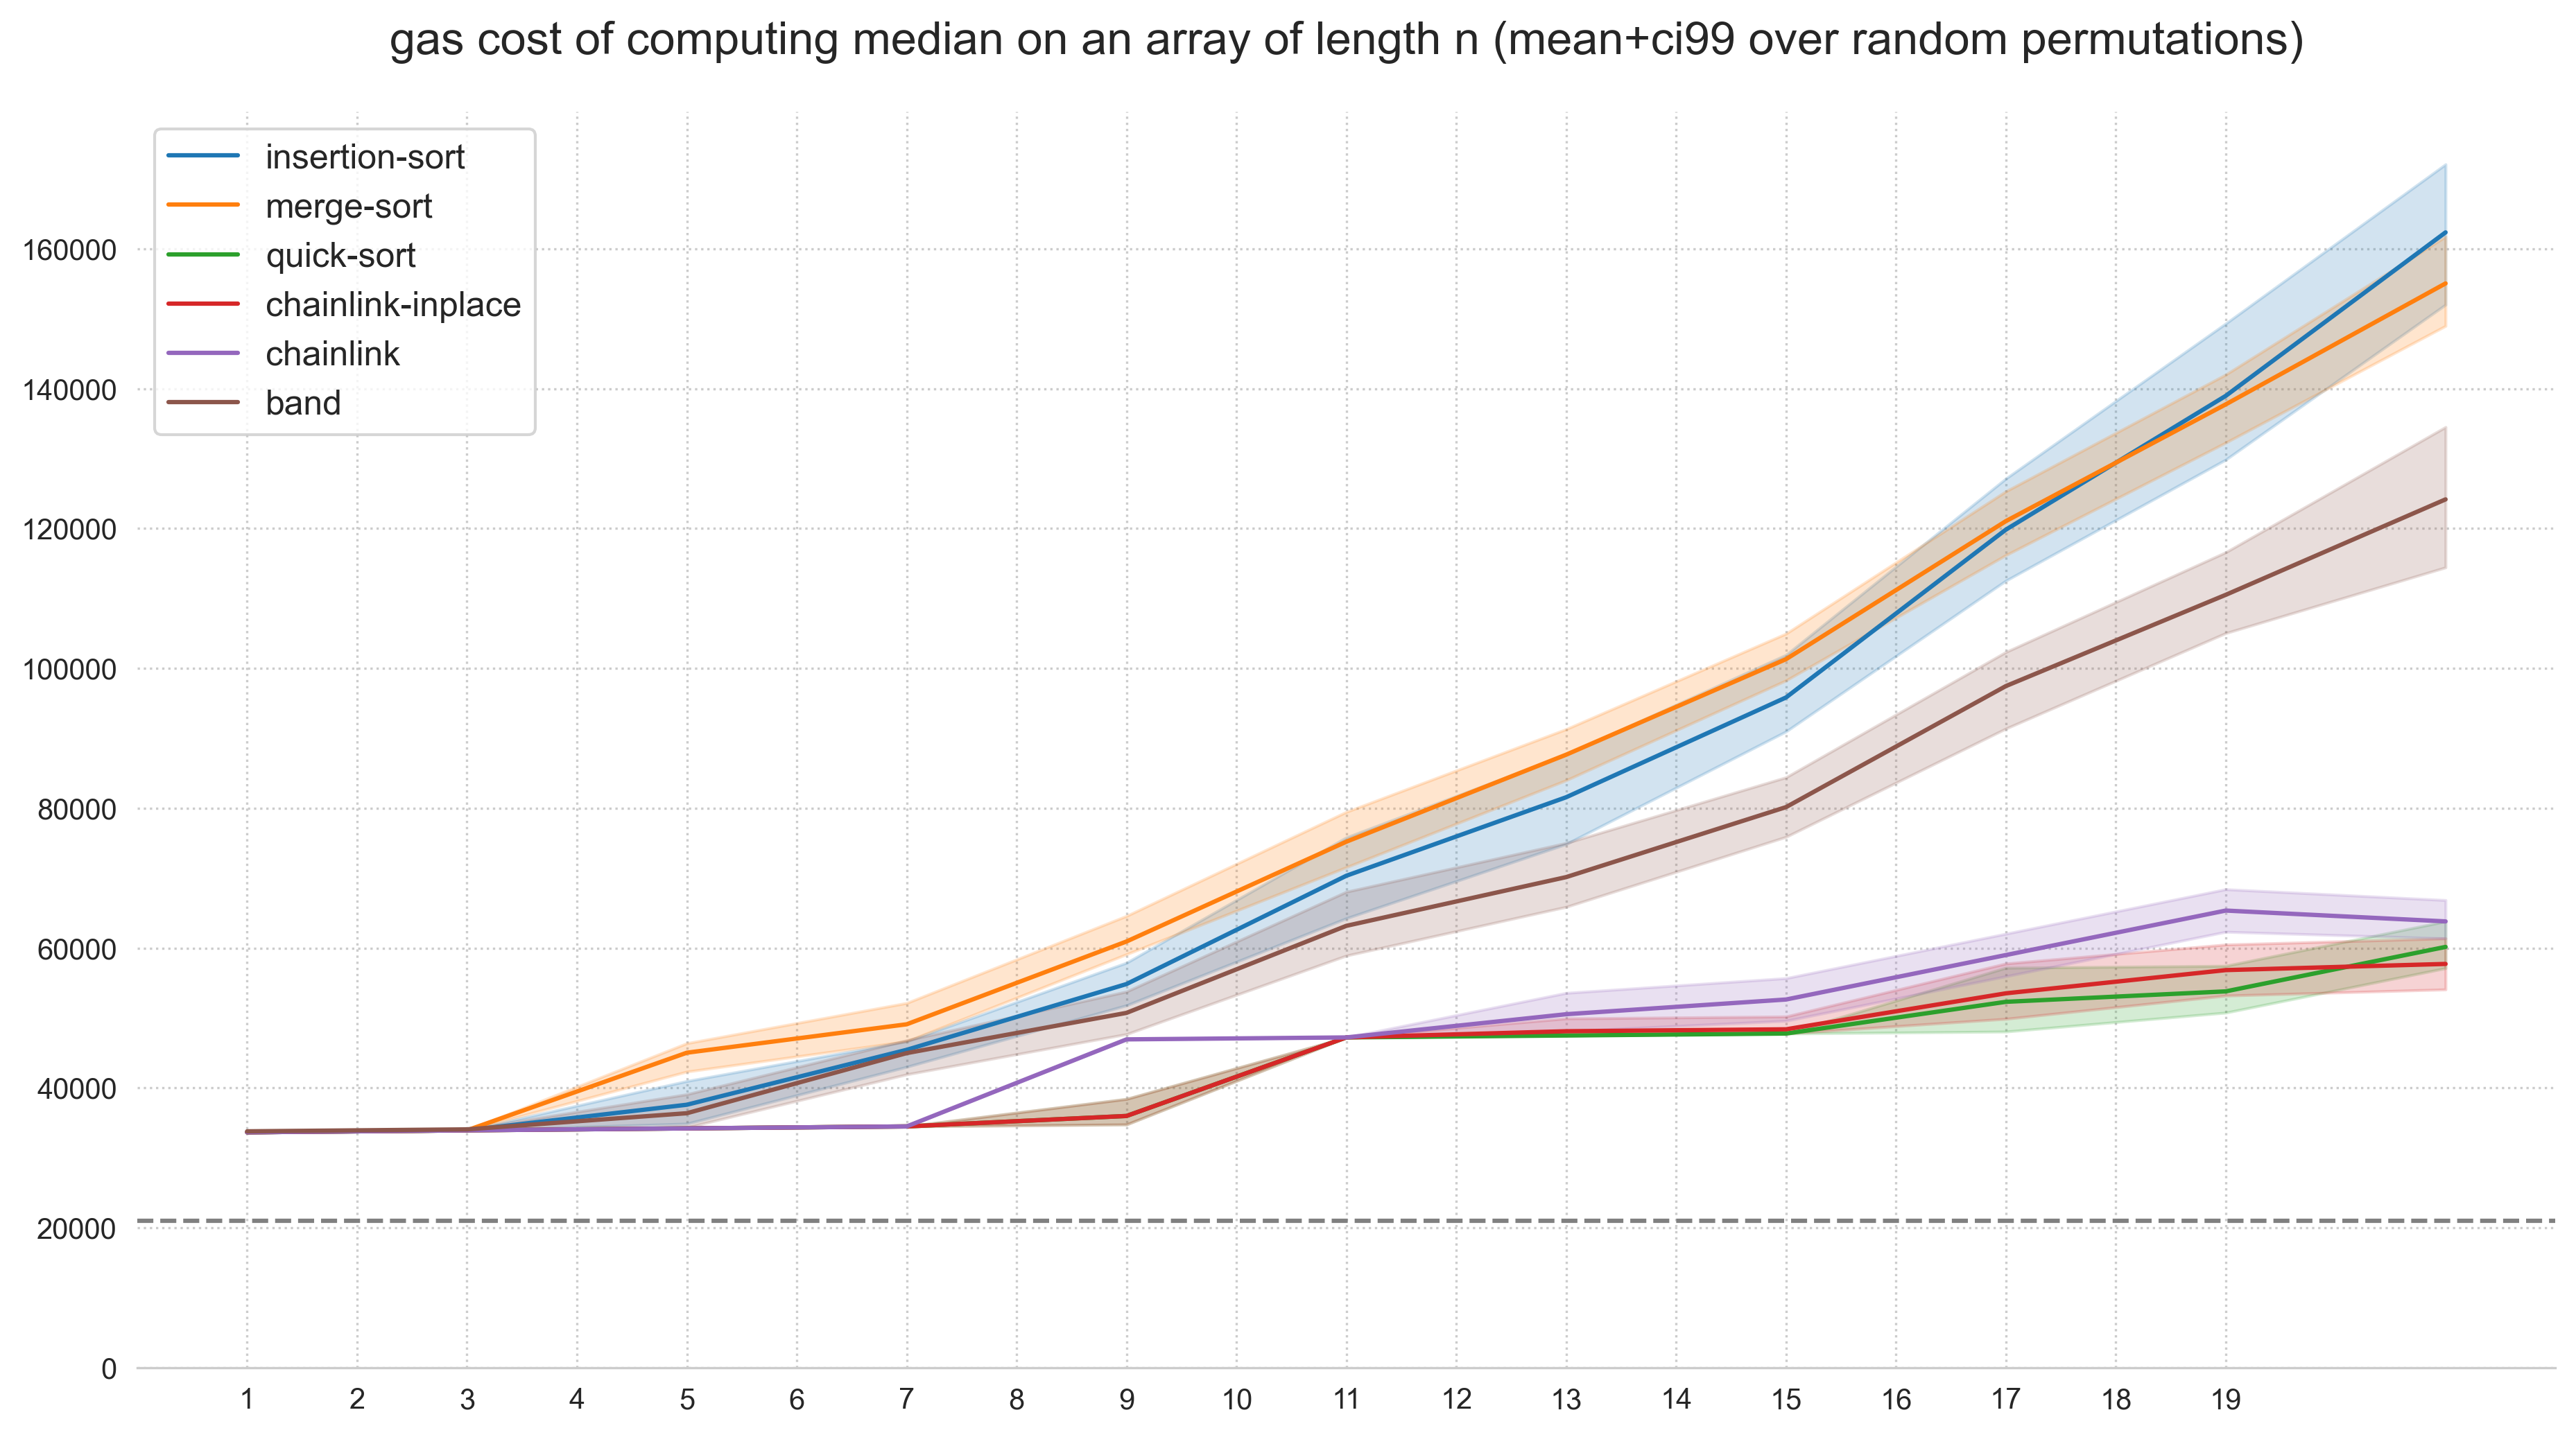

In [37]:
# first: make sure testing on same arrays
#'''
test_arrs = set()
for typ in df.type.unique():
    if not test_arrs:
        test_arrs = set(df[df.type == typ].arr.tolist())
    else:
        test_arrs &= set(df[df.type == typ].arr.tolist())
#'''

plt.figure(figsize=(15,8), dpi=300)

#g = sns.lineplot(data=df[df.arr.isin(test_arrs)], x="length", y="gas_cost", hue="type", ci=99)#, palette=palette5);
#g = sns.lineplot(data=df[df.type != 'band'], x="length", y="gas_cost", hue="type", ci=99)#, palette=palette5);
g = sns.lineplot(data=df, x="length", y="gas_cost", hue="type", ci=99)#, palette=palette5);

# mark minimum gas for any txn
plt.axhline(21_000, ls='--', color='grey');


### aesthetics ###

sns.set_style(
    "whitegrid", {
        'grid.linestyle': ':'
})

plt.xlim(0,);
plt.ylim(0,);

g.set_title(
    'gas cost of computing median on an array of length n (mean+ci99 over random permutations)',
    size=16, pad=20
)
g.set_xlabel('', size=12)
g.set_xticks(list(range(1, MAX_ARRAY_SIZE)))
g.set_ylabel('')
plt.legend(fontsize=12)
g.tick_params(labelsize=10)

sns.despine(left=True);